## Сегментация изображений клеток

Вам предстоит обучить модель сегментировать изображения с дрожжевыми клетками и микроструктурами (см. [06_segmentation.ipynb](../workshops/06_segmentation.ipynb)), по пути поэкспериментировав с разными архитектурами и функцими ошибки.

### Задание 1 (2 балл). Метрики сегментации
Перед экспериментами нужно определиться с метриками. Выберите 3-5 метрик, по которым вы будете оценивать качество модели. В этом задании объясните свой выбор и найдите нужные метрики в `torchvision` (а если их нет - реализуйте самостоятельно, здесь вам может помочь [05_lightning_etc.ipynb](../workshops/05_lightning_etc.ipynb))

In [ ]:
%с

Note: you may need to restart the kernel to use updated packages.


In [4]:
from os import mkdir
from pathlib import Path


import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from numpy.ma.core import outer
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms
import torchmetrics.classification
from typing import Any
from lightning.pytorch.utilities.types import STEP_OUTPUT

def create_classification_metrics(
    num_classes: int, prefix: str
) -> torchmetrics.MetricCollection:
    return torchmetrics.MetricCollection(
        [
            torchmetrics.Accuracy(task="multiclass", num_classes=num_classes),
            torchmetrics.Precision(task="multiclass", num_classes=num_classes, average="macro"),
            torchmetrics.Recall(task="multiclass", num_classes=num_classes, average="macro"),
            torchmetrics.JaccardIndex(task="multiclass", num_classes=num_classes),
            torchmetrics.Dice(num_classes=num_classes, average="macro"),
        ],
        prefix=prefix,
    )


### Задание 2 (4 балла). Обучение модели
Возьмите модель и датасеты из практики по сегментации и запустите обучение.

Указания:
- Каждую эпоху сохраняйте значения ошибки и выбранные в задании 1 метрики как для обучающего датасета (`train`), так и для валидационного (`val`).
- Каждую эпоху сохраняйте примеры работы модели на 8 случайных изображениях из валидационного датасета (одной картинкой, как в практике).
- После окончания обучения выведите графики значений ваших метрик и примеры предсказаний (достаточно 4-5 изображений: для первой эпохи, 2-3 в середине обучения и ндля последней эпохи).
- Можете использовать `lightning` (вместо `lightning.pytorch.loggers.TensorBoardLogger` можно использовать `lightning.pytorch.loggers.CSVLogger`, а сохранение изображений можете реализовать как `lightning.pytorch.Callback`), а можете всё написать вручную.

In [ ]:
# ! wget https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
# ! unzip yeast_cell_in_microstructures_dataset.zip -d yeast_cell_in_microstructures_dataset

Archive:  yeast_cell_in_microstructures_dataset.zip
replace yeast_cell_in_microstructures_dataset/test/bounding_boxes/395.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
class YeastDataset(Dataset):
    def __init__(self, subset_dir: Path) -> None:
        super().__init__()
        self.subset_dir = subset_dir
        self.items = list((self.subset_dir / "inputs").glob("*.pt"))

    def __getitem__(self, index: int) -> tuple[Tensor, dict[str, Tensor]]:
        # нужно вернуть пару
        # тензор изображения C x W x H
        # словарь с ключами boxes, masks, labels
        image_path = self.items[index]
        image = torch.load(image_path, weights_only=True).unsqueeze(
            0
        )  # (W, H) -> (1, W, H)
        classes = (
            torch.load(
                self.subset_dir / "classes" / image_path.parts[-1], weights_only=True
            )
            + 1
        )  # 0 класс - фон
        masks = torch.load(
            self.subset_dir / "instances" / image_path.parts[-1], weights_only=True
        )
        boxes = torch.load(
            self.subset_dir / "bounding_boxes" / image_path.parts[-1], weights_only=True
        )
        return image, dict(
            boxes=boxes,
            labels=classes,
            masks=masks,
        )

    def __len__(self) -> int:
        return len(self.items)

In [6]:
class YeastSemanticSegmDataset(YeastDataset):
    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        image, annotation = super().__getitem__(index)
        # нужно сформировать маску: тензор размера W x H, где для каждого пиксела указан класс
        mask = (
            (annotation["masks"] * annotation["labels"].view(-1, 1, 1)).sum(dim=0)
        ).long()

        return image, mask

In [7]:
from typing import Any, Callable, Type

from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from torch.utils.data import DataLoader

_collate_fn_t = Callable[[list[tuple[Tensor, Any]]], Any]


class Datamodule(L.LightningDataModule):
    def __init__(
        self,
        datadir: Path,
        dataset_class: Type[Dataset],
        batch_size: int,
        train_subdir: str = "train",
        val_subdir: str = "val",
        test_subdir: str = "test",
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataset_class = dataset_class
        self.train_dir = datadir / train_subdir
        self.val_dir = datadir / val_subdir
        self.test_dir = datadir / test_subdir

    @property
    def collate_fn(self) -> _collate_fn_t | None:
        if self.dataset_class == YeastSemanticSegmDataset:
            return None
        else:
            return lambda batch: tuple(zip(*batch))

    def setup(self, stage: str) -> None:
        if stage in ("fit", "validate"):
            self.val_dataset = self.dataset_class(self.val_dir)
        if stage == "fit":
            self.train_dataset = self.dataset_class(self.train_dir)
        elif stage == "test":
            self.test_dataset = self.dataset_class(self.test_dir)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(
        self, in_channels: int, out_channels: int, mid_channels: int | None = None
    ) -> None:
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(
        self, in_channels: int, out_channels: int, bilinear: bool = True
    ) -> None:
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_prev: Tensor, x_skip: Tensor) -> Tensor:
        x_prev = self.up(x_prev)
        # input is BCHW
        d_height = x_skip.size()[2] - x_prev.size()[2]
        d_width = x_skip.size()[3] - x_prev.size()[3]

        x_prev = F.pad(
            x_prev,
            [
                d_width // 2,
                d_width - d_width // 2,
                d_height // 2,
                d_height - d_height // 2,
            ],
        )
        x = torch.cat([x_skip, x_prev], dim=1)
        return self.conv(x)

def masks_to_rgb(masks: Tensor) -> Tensor:
    """
    Преобразует тензор с бинарными масками произвольного кол-ва объектов (до 9)
    в тензор с тремя каналами, который можно конвертировать в RGB изображение

    Args:
        masks (Tensor): тензор с бинарными масками N отдельных объектов размера N x W x H
    """
    _colors = torch.tensor([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.5, 0.0, 0.5],
        [0.5, 0.5, 0.0],
        [0.0, 0.5, 0.5],
        [0.5, 0.3, 0.2],
        [0.2, 0.3, 0.5],
        [0.2, 0.5, 0.3],
    ])[:len(masks)]
    return (masks.unsqueeze(0) * _colors.T.unsqueeze(-1).unsqueeze(-1)).sum(dim=1)

In [49]:
class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        если используется билинейная интерполяция вместо обратной свёртки,
        то размер последнего (самого большого) канала делаем вдвое меньшеNo module named 'pandas'

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        Если используется билинейная интерполяция вместо обратной свёртки,
        то размер первого (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                    zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
                )
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        # создаём список для хранения промежуточных активаций
        xs = []
        # делаем входную свёртку
        x = self.in_conv(x)

        # downscaling
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        # разворачиваем промежуточные активации и делаем upscaling
        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        # финальная свёртка для получения логитов пикселей
        logits = self.head(x)
        return logits

In [10]:
dataset_dir = Path("yeast_cell_in_microstructures_dataset")
train_dir = dataset_dir / "train"
val_dir = dataset_dir / "val"

In [ ]:
import os
import pandas as pd
import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import save_image
from torchmetrics import MetricCollection
from typing import Any

class Lit(L.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        learning_rate: float = 0.001,
        optimizer: torch.optim.Optimizer = None,
        use_weights: bool = False,
        save_images: bool = True
    ) -> None:
        super().__init__()
        self.save_hyperparameters(ignore=["optimizer"])
        self.model = model
        self.learning_rate = learning_rate
        self.use_weights = use_weights
        self.save_images = save_images

        self.optimizer = optimizer if optimizer else torch.optim.Adam(
            self.model.parameters(), lr=self.learning_rate
        )


        self.train_metrics = create_classification_metrics(num_classes=3, prefix="train_")
        self.val_metrics = create_classification_metrics(num_classes=3, prefix="val_")

        # CSV для логирования
        self.metrics_log_path = "training_metrics.csv"
        if os.path.exists(self.metrics_log_path):
            os.remove(self.metrics_log_path)

    def training_step(self, batch, batch_idx) -> STEP_OUTPUT:
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)  
        y_hat = self.model(x)

        loss = F.cross_entropy(y_hat, y)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.train_metrics.update(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx) -> STEP_OUTPUT:
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self.model(x)

        loss = F.cross_entropy(y_hat, y)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.val_metrics.update(y_hat, y)
        return {"loss": loss, "preds": y_hat, "targets": y}

    def on_train_epoch_end(self):
        train_results = self.train_metrics.compute()
        val_results = self.val_metrics.compute()

        log_data = {"epoch": self.current_epoch}
        log_data.update({k: v.item() for k, v in train_results.items()})
        log_data.update({k: v.item() for k, v in val_results.items()})

        df = pd.DataFrame([log_data])
        df.to_csv(self.metrics_log_path, mode='a', header=not os.path.exists(self.metrics_log_path), index=False)

        print(f"Epoch {self.current_epoch}: {log_data}")

        self.train_metrics.reset()
        self.val_metrics.reset()

    def configure_optimizers(self):
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            self.optimizer, milestones=[5, 10, 15], gamma=0.1
        )
        return {"optimizer": self.optimizer, "lr_scheduler": scheduler}

    def on_validation_epoch_end(self):
        print(f"save_images is {self.save_images}")  # Проверка
        if self.save_images:
            self.save_predictions()

    def save_predictions(self):
        print(f"Saving predictions for epoch {self.trainer.current_epoch}...") 
        save_dir = f"saved_images/epoch_{self.trainer.current_epoch}"
        os.makedirs(save_dir, exist_ok=True)

        val_dl = self.trainer.datamodule.val_dataloader()
        if val_dl is None:
            print("Validation dataloader is None! Check your datamodule.")
            return

        try:
            batch, _ = next(iter(val_dl))
        except StopIteration:
            print("Validation dataloader is empty!")
            return

        batch = batch.to(self.device, dtype=torch.float32) 
        predictions = self.model(batch).argmax(dim=1).cpu() 

        input_grid = torchvision.utils.make_grid(batch.cpu(), nrow=4, normalize=True)
        save_image(input_grid, os.path.join(save_dir, "input.png"))

        masks_grid = torchvision.utils.make_grid(
            torch.nn.functional.one_hot(predictions, 3).permute(0, 3, 1, 2)[:, 1:].float(),
            nrow=4
        )
        save_image(masks_grid, os.path.join(save_dir, "output.png"))

        print(f"Saved predictions for epoch {self.trainer.current_epoch} in {save_dir}")

In [12]:
torch.manual_seed(42)
datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=8,
)
datamodule.setup("fit")

model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)

lit_module = Lit(model, learning_rate=0.01)

/home/ne_ravilka/miniconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [13]:
from lightning.pytorch.loggers import TensorBoardLogger

trainer = L.Trainer(
    accelerator="auto",
    max_epochs= 10,
    logger=TensorBoardLogger(save_dir="."),
)

trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ne_ravilka/miniconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


save_images is True
Saving predictions for epoch 0...
Saved predictions for epoch 0 in saved_images/epoch_0


/home/ne_ravilka/miniconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/ne_ravilka/miniconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 0...
Saved predictions for epoch 0 in saved_images/epoch_0
Epoch 0: {'epoch': 0, 'train_MulticlassAccuracy': 0.8526848554611206, 'train_MulticlassPrecision': 0.6807777285575867, 'train_MulticlassRecall': 0.6521865129470825, 'train_MulticlassJaccardIndex': 0.5356250405311584, 'train_Dice': 0.6518255472183228, 'val_MulticlassAccuracy': 0.8047161102294922, 'val_MulticlassPrecision': 0.6040610671043396, 'val_MulticlassRecall': 0.6084063649177551, 'val_MulticlassJaccardIndex': 0.47588008642196655, 'val_Dice': 0.5978143215179443}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 1...
Saved predictions for epoch 1 in saved_images/epoch_1
Epoch 1: {'epoch': 1, 'train_MulticlassAccuracy': 0.9038683772087097, 'train_MulticlassPrecision': 0.7857347726821899, 'train_MulticlassRecall': 0.7658634185791016, 'train_MulticlassJaccardIndex': 0.6647095680236816, 'train_Dice': 0.774978518486023, 'val_MulticlassAccuracy': 0.9112022519111633, 'val_MulticlassPrecision': 0.8353897333145142, 'val_MulticlassRecall': 0.7904118299484253, 'val_MulticlassJaccardIndex': 0.7052767276763916, 'val_Dice': 0.8109734058380127}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 2...
Saved predictions for epoch 2 in saved_images/epoch_2
Epoch 2: {'epoch': 2, 'train_MulticlassAccuracy': 0.9317529797554016, 'train_MulticlassPrecision': 0.8623723983764648, 'train_MulticlassRecall': 0.8456331491470337, 'train_MulticlassJaccardIndex': 0.7599791288375854, 'train_Dice': 0.8537544012069702, 'val_MulticlassAccuracy': 0.9358380436897278, 'val_MulticlassPrecision': 0.8819459676742554, 'val_MulticlassRecall': 0.8743212223052979, 'val_MulticlassJaccardIndex': 0.79188072681427, 'val_Dice': 0.8773051500320435}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 3...
Saved predictions for epoch 3 in saved_images/epoch_3
Epoch 3: {'epoch': 3, 'train_MulticlassAccuracy': 0.9499809741973877, 'train_MulticlassPrecision': 0.9041491746902466, 'train_MulticlassRecall': 0.9016050100326538, 'train_MulticlassJaccardIndex': 0.8293725252151489, 'train_Dice': 0.9028726816177368, 'val_MulticlassAccuracy': 0.9445470571517944, 'val_MulticlassPrecision': 0.9282202124595642, 'val_MulticlassRecall': 0.8637577295303345, 'val_MulticlassJaccardIndex': 0.8135316371917725, 'val_Dice': 0.8916687965393066}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 4...
Saved predictions for epoch 4 in saved_images/epoch_4
Epoch 4: {'epoch': 4, 'train_MulticlassAccuracy': 0.9554088711738586, 'train_MulticlassPrecision': 0.9156677722930908, 'train_MulticlassRecall': 0.9183983206748962, 'train_MulticlassJaccardIndex': 0.8510575294494629, 'train_Dice': 0.916999101638794, 'val_MulticlassAccuracy': 0.9484097361564636, 'val_MulticlassPrecision': 0.9318668842315674, 'val_MulticlassRecall': 0.8933224678039551, 'val_MulticlassJaccardIndex': 0.8399949073791504, 'val_Dice': 0.9111320972442627}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 5...
Saved predictions for epoch 5 in saved_images/epoch_5
Epoch 5: {'epoch': 5, 'train_MulticlassAccuracy': 0.9647969603538513, 'train_MulticlassPrecision': 0.9371703863143921, 'train_MulticlassRecall': 0.9364070892333984, 'train_MulticlassJaccardIndex': 0.8833178281784058, 'train_Dice': 0.9367537498474121, 'val_MulticlassAccuracy': 0.9639008045196533, 'val_MulticlassPrecision': 0.9371524453163147, 'val_MulticlassRecall': 0.9395079016685486, 'val_MulticlassJaccardIndex': 0.8860461711883545, 'val_Dice': 0.9382317662239075}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 6...
Saved predictions for epoch 6 in saved_images/epoch_6
Epoch 6: {'epoch': 6, 'train_MulticlassAccuracy': 0.9666948914527893, 'train_MulticlassPrecision': 0.9405121803283691, 'train_MulticlassRecall': 0.9413121938705444, 'train_MulticlassJaccardIndex': 0.8902904987335205, 'train_Dice': 0.9408984184265137, 'val_MulticlassAccuracy': 0.9658632874488831, 'val_MulticlassPrecision': 0.9383519887924194, 'val_MulticlassRecall': 0.9457732439041138, 'val_MulticlassJaccardIndex': 0.8923698663711548, 'val_Dice': 0.9419718384742737}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 7...
Saved predictions for epoch 7 in saved_images/epoch_7
Epoch 7: {'epoch': 7, 'train_MulticlassAccuracy': 0.9665900468826294, 'train_MulticlassPrecision': 0.9397444725036621, 'train_MulticlassRecall': 0.9417426586151123, 'train_MulticlassJaccardIndex': 0.8899766206741333, 'train_Dice': 0.9407116174697876, 'val_MulticlassAccuracy': 0.9664204120635986, 'val_MulticlassPrecision': 0.9423049688339233, 'val_MulticlassRecall': 0.9428929090499878, 'val_MulticlassJaccardIndex': 0.8934541940689087, 'val_Dice': 0.9425987005233765}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 8...
Saved predictions for epoch 8 in saved_images/epoch_8
Epoch 8: {'epoch': 8, 'train_MulticlassAccuracy': 0.9675177335739136, 'train_MulticlassPrecision': 0.9438695907592773, 'train_MulticlassRecall': 0.9405761361122131, 'train_MulticlassJaccardIndex': 0.892586350440979, 'train_Dice': 0.9422155022621155, 'val_MulticlassAccuracy': 0.9665147662162781, 'val_MulticlassPrecision': 0.945545494556427, 'val_MulticlassRecall': 0.9396950006484985, 'val_MulticlassJaccardIndex': 0.8933976888656616, 'val_Dice': 0.9425987005233765}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 9...
Saved predictions for epoch 9 in saved_images/epoch_9


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: {'epoch': 9, 'train_MulticlassAccuracy': 0.9685264825820923, 'train_MulticlassPrecision': 0.9441664218902588, 'train_MulticlassRecall': 0.9453505277633667, 'train_MulticlassJaccardIndex': 0.8968324661254883, 'train_Dice': 0.9447394013404846, 'val_MulticlassAccuracy': 0.9669581651687622, 'val_MulticlassPrecision': 0.948137640953064, 'val_MulticlassRecall': 0.9381849765777588, 'val_MulticlassJaccardIndex': 0.8943021297454834, 'val_Dice': 0.9430913925170898}


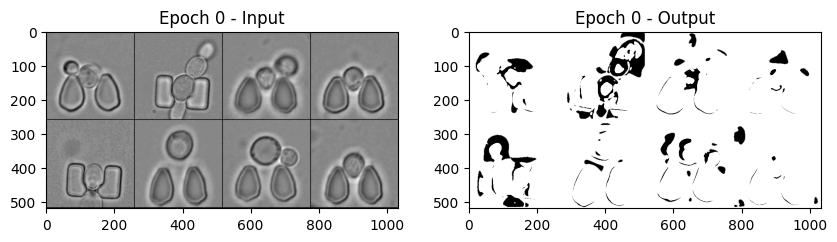

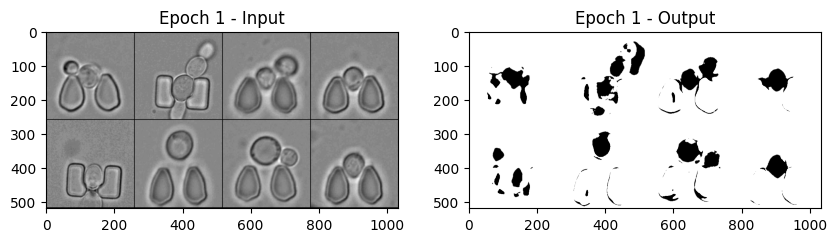

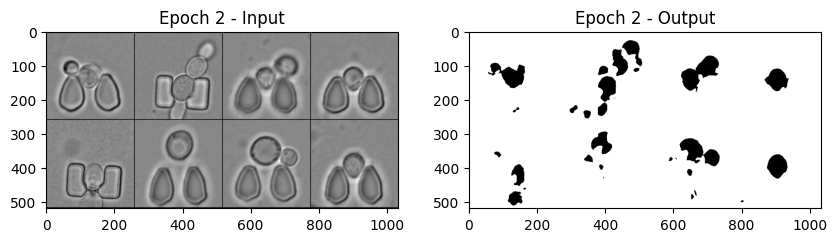

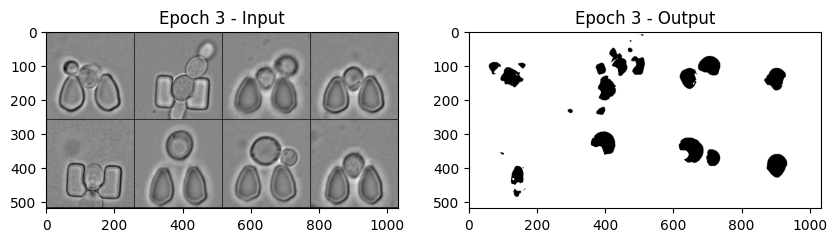

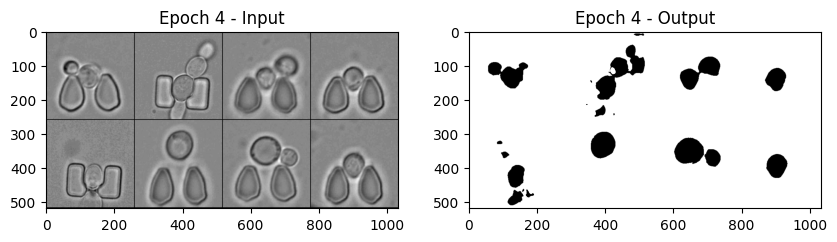

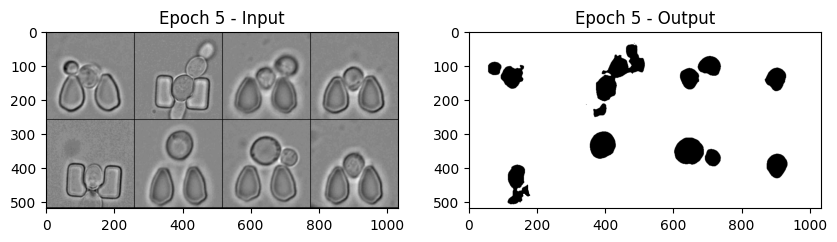

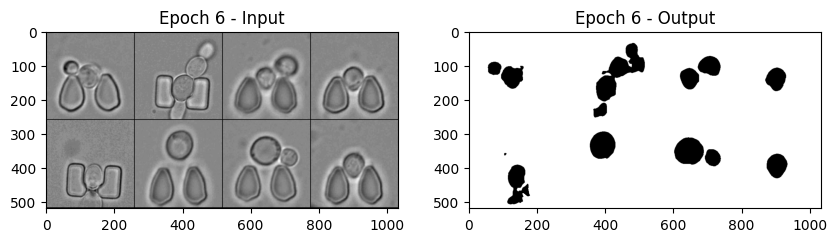

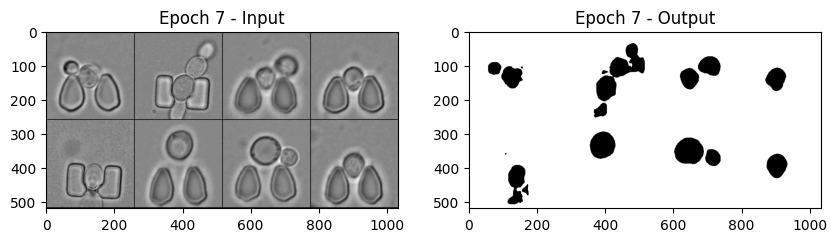

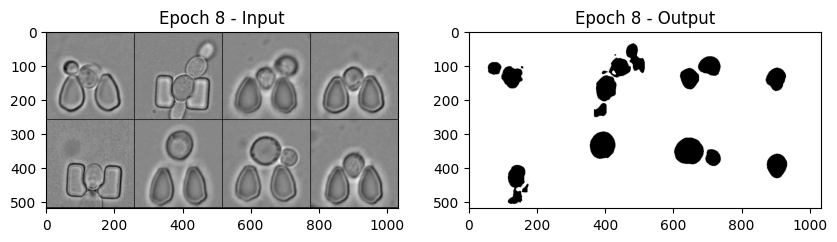

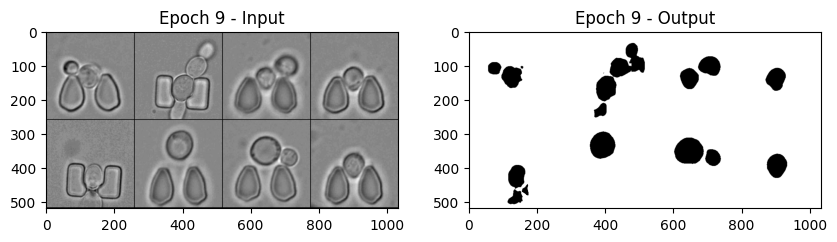

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

def show_images_for_epochs(epochs):
    for epoch in epochs:
        input_img = Image.open(f"saved_images/epoch_{epoch}/input.png")
        output_img = Image.open(f"saved_images/epoch_{epoch}/output.png")
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_img)
        plt.title(f"Epoch {epoch} - Input")
        
        plt.subplot(1, 2, 2)
        plt.imshow(output_img)
        plt.title(f"Epoch {epoch} - Output")
        
        plt.show()

epochs_to_show = [i for i in range(10)]
show_images_for_epochs(epochs_to_show)


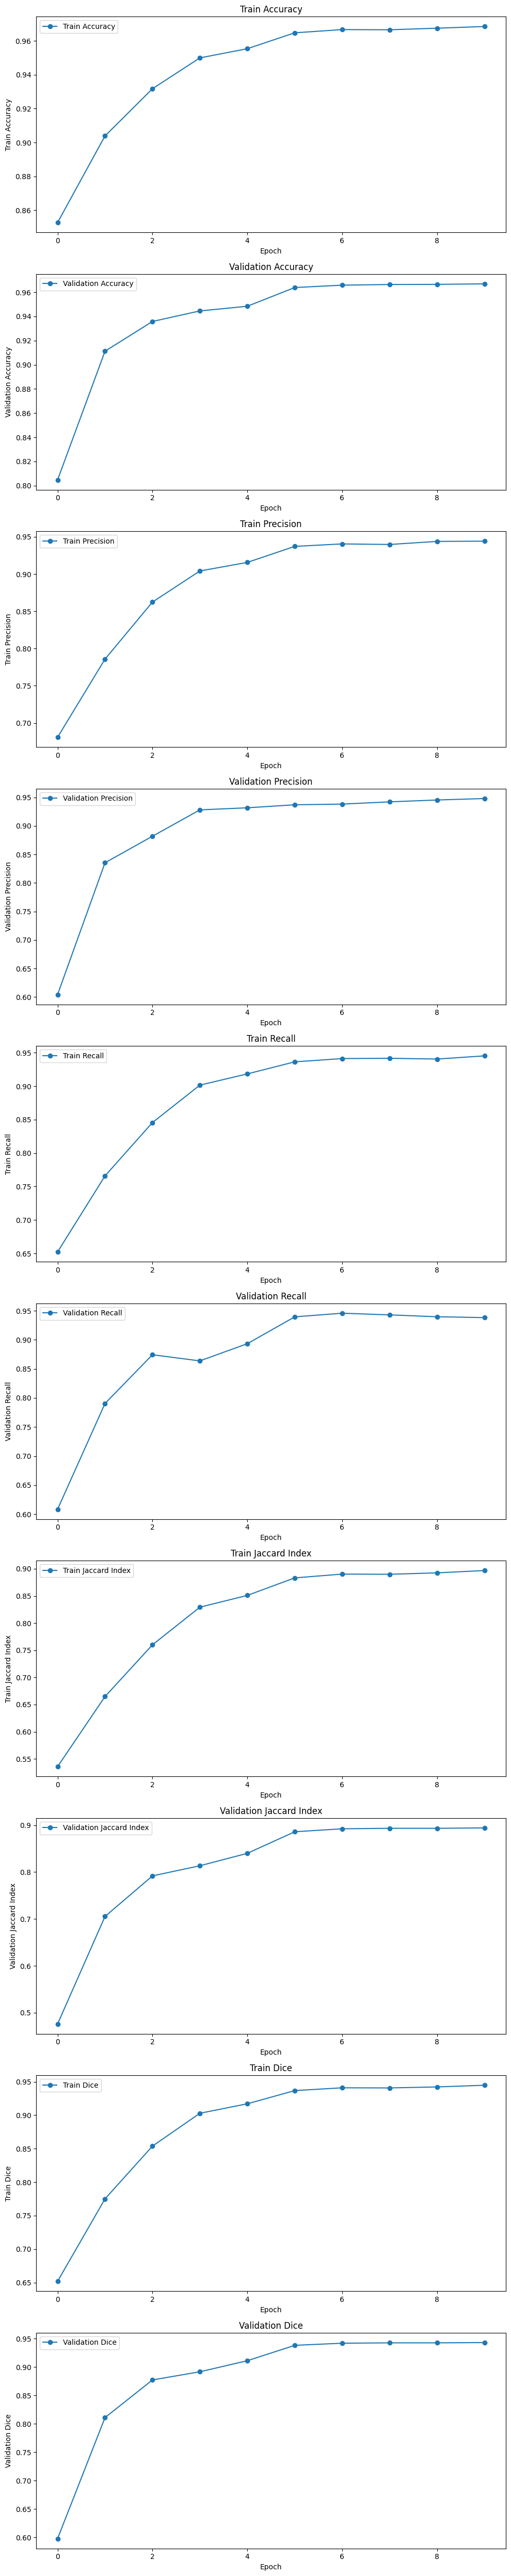

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('training_metrics.csv')

def plot_metrics_from_csv(df):
    metrics = [
        ("train_MulticlassAccuracy", "Train Accuracy"),
        ("val_MulticlassAccuracy", "Validation Accuracy"),
        ("train_MulticlassPrecision", "Train Precision"),
        ("val_MulticlassPrecision", "Validation Precision"),
        ("train_MulticlassRecall", "Train Recall"),
        ("val_MulticlassRecall", "Validation Recall"),
        ("train_MulticlassJaccardIndex", "Train Jaccard Index"),
        ("val_MulticlassJaccardIndex", "Validation Jaccard Index"),
        ("train_Dice", "Train Dice"),
        ("val_Dice", "Validation Dice")
    ]
    
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, num_metrics * 5))
    
    for i, (metric_col, metric_name) in enumerate(metrics):
        axes[i].plot(df['epoch'], df[metric_col], label=metric_name, marker='o')
        axes[i].set_title(metric_name)
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric_name)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

plot_metrics_from_csv(df)



### Задание 3 (3 балла). Выбор другой функции ошибки

Полезная ссылка:
https://www.jeremyjordan.me/semantic-segmentation/#loss

Повторите эксперимент из задания 2, но попробуйте модифицировать функцию ошибки:
- (2 балла) учитывайте пиксели на границе объектов с большим весом, как предлагается в статье [U-Net](https://arxiv.org/abs/1505.04597)
- (1 балл) используйте soft Dice loss

Опишите свои наблюдения, что изменилось? Обратите внимание на скорость обучения, визуальные артефакты предсказаний, динамику метрик.


In [ ]:
import os
import pandas as pd
import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import save_image
from torchmetrics import MetricCollection
from typing import Any

def compute_boundary_gradients(image):
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(image.device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(image.device)

    grad_x = F.conv2d(image, sobel_x, padding=1)
    grad_y = F.conv2d(image, sobel_y, padding=1)
    
    return torch.sqrt(grad_x**2 + grad_y**2)

def soft_dice_loss(pred, target, epsilon=1e-6):
    """ Вычисляет Soft Dice Loss """
    pred = torch.softmax(pred, dim=1) 
    target = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2)  
    
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target)
    
    return 1 - (2. * intersection + epsilon) / (union + epsilon)


def boundary_aware_dice_loss(pred, target, image, alpha=1.0):
    grad_image = compute_boundary_gradients(image)
    boundary_weight = torch.exp(-grad_image)  
    
    loss = soft_dice_loss(pred, target)
    weighted_loss = (loss * boundary_weight).mean()  
    
    return weighted_loss

class LitWithBoundaryLoss(L.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        learning_rate: float = 0.001,
        optimizer: torch.optim.Optimizer = None,
        use_weights: bool = False,
        save_images: bool = True,
        alpha: float = 1.0  # Коэффициент для весов границ
    ) -> None:
        super().__init__()
        self.save_hyperparameters(ignore=["optimizer"])
        self.model = model
        self.learning_rate = learning_rate
        self.use_weights = use_weights
        self.save_images = save_images
        self.alpha = alpha

        self.optimizer = optimizer if optimizer else torch.optim.Adam(
            self.model.parameters(), lr=self.learning_rate
        )

        self.train_metrics = create_classification_metrics(num_classes=3, prefix="train_")
        self.val_metrics = create_classification_metrics(num_classes=3, prefix="val_")

        self.metrics_log_path = "training_metrics_boundary_loss.csv"
        if os.path.exists(self.metrics_log_path):
            os.remove(self.metrics_log_path)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self.model(x)

        loss = boundary_aware_dice_loss(y_hat, y, x, alpha=self.alpha)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.train_metrics.update(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self.model(x)

        loss = boundary_aware_dice_loss(y_hat, y, x, alpha=self.alpha)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.val_metrics.update(y_hat, y)
        return {"loss": loss, "preds": y_hat, "targets": y}

    def on_train_epoch_end(self):
        train_results = self.train_metrics.compute()
        val_results = self.val_metrics.compute()

        log_data = {"epoch": self.current_epoch}
        log_data.update({k: v.item() for k, v in train_results.items()})
        log_data.update({k: v.item() for k, v in val_results.items()})

        df = pd.DataFrame([log_data])
        df.to_csv(self.metrics_log_path, mode='a', header=not os.path.exists(self.metrics_log_path), index=False)

        print(f"Epoch {self.current_epoch}: {log_data}")

        self.train_metrics.reset()
        self.val_metrics.reset()

    def configure_optimizers(self):
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            self.optimizer, milestones=[5, 10, 15], gamma=0.1
        )
        return {"optimizer": self.optimizer, "lr_scheduler": scheduler}

    def on_validation_epoch_end(self):
        print(f"save_images is {self.save_images}")  # Проверка
        if self.save_images:
            self.save_predictions()

    def save_predictions(self):
        print(f"Saving predictions for epoch {self.trainer.current_epoch}...") 
        save_dir = f"saved_images/epoch_{self.trainer.current_epoch}"
        os.makedirs(save_dir, exist_ok=True)

        val_dl = self.trainer.datamodule.val_dataloader()
        if val_dl is None:
            print("Validation dataloader is None! Check your datamodule.")
            return

        try:
            batch, _ = next(iter(val_dl))
        except StopIteration:
            print("Validation dataloader is empty!")
            return

        batch = batch.to(self.device, dtype=torch.float32) 
        predictions = self.model(batch).argmax(dim=1).cpu() 

        input_grid = torchvision.utils.make_grid(batch.cpu(), nrow=4, normalize=True)
        save_image(input_grid, os.path.join(save_dir, "input.png"))

        masks_grid = torchvision.utils.make_grid(
            torch.nn.functional.one_hot(predictions, 3).permute(0, 3, 1, 2)[:, 1:].float(),
            nrow=4
        )
        save_image(masks_grid, os.path.join(save_dir, "output.png"))

        print(f"Saved predictions for epoch {self.trainer.current_epoch} in {save_dir}")


In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger


model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)
lit_boundary_module = LitWithBoundaryLoss(
    model=model,  
    learning_rate=0.001,
    save_images=True,
    alpha=1.0  
)

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    logger=TensorBoardLogger(save_dir="."),
)

trainer.fit(
    model=lit_boundary_module,
    datamodule=datamodule,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)
87        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 0...
Saved predictions for epoch 0 in saved_images/epoch_0


/home/ne_ravilka/miniconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/ne_ravilka/miniconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 0...
Saved predictions for epoch 0 in saved_images/epoch_0
Epoch 0: {'epoch': 0, 'train_MulticlassAccuracy': 0.8551062345504761, 'train_MulticlassPrecision': 0.6760245561599731, 'train_MulticlassRecall': 0.6795187592506409, 'train_MulticlassJaccardIndex': 0.5431640148162842, 'train_Dice': 0.6549656391143799, 'val_MulticlassAccuracy': 0.688433825969696, 'val_MulticlassPrecision': 0.6091769933700562, 'val_MulticlassRecall': 0.6578092575073242, 'val_MulticlassJaccardIndex': 0.4601459503173828, 'val_Dice': 0.5932716727256775}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 1...
Saved predictions for epoch 1 in saved_images/epoch_1
Epoch 1: {'epoch': 1, 'train_MulticlassAccuracy': 0.9149240851402283, 'train_MulticlassPrecision': 0.809546947479248, 'train_MulticlassRecall': 0.7894400358200073, 'train_MulticlassJaccardIndex': 0.6797747611999512, 'train_Dice': 0.7847782373428345, 'val_MulticlassAccuracy': 0.9014344215393066, 'val_MulticlassPrecision': 0.7768678069114685, 'val_MulticlassRecall': 0.7504180073738098, 'val_MulticlassJaccardIndex': 0.6329694986343384, 'val_Dice': 0.7376047968864441}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 2...
Saved predictions for epoch 2 in saved_images/epoch_2
Epoch 2: {'epoch': 2, 'train_MulticlassAccuracy': 0.9155555963516235, 'train_MulticlassPrecision': 0.8274810314178467, 'train_MulticlassRecall': 0.7568670511245728, 'train_MulticlassJaccardIndex': 0.6522424817085266, 'train_Dice': 0.7554038763046265, 'val_MulticlassAccuracy': 0.946104109287262, 'val_MulticlassPrecision': 0.9334434270858765, 'val_MulticlassRecall': 0.8630146980285645, 'val_MulticlassJaccardIndex': 0.8067536354064941, 'val_Dice': 0.8865212202072144}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 3...
Saved predictions for epoch 3 in saved_images/epoch_3
Epoch 3: {'epoch': 3, 'train_MulticlassAccuracy': 0.9601861834526062, 'train_MulticlassPrecision': 0.926532506942749, 'train_MulticlassRecall': 0.9256234765052795, 'train_MulticlassJaccardIndex': 0.8647570013999939, 'train_Dice': 0.9255431294441223, 'val_MulticlassAccuracy': 0.9586293697357178, 'val_MulticlassPrecision': 0.926236629486084, 'val_MulticlassRecall': 0.9307821989059448, 'val_MulticlassJaccardIndex': 0.8685952425003052, 'val_Dice': 0.9279109835624695}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 4...
Saved predictions for epoch 4 in saved_images/epoch_4
Epoch 4: {'epoch': 4, 'train_MulticlassAccuracy': 0.9598802924156189, 'train_MulticlassPrecision': 0.9296702146530151, 'train_MulticlassRecall': 0.9182989597320557, 'train_MulticlassJaccardIndex': 0.8613476753234863, 'train_Dice': 0.9233057498931885, 'val_MulticlassAccuracy': 0.9632092118263245, 'val_MulticlassPrecision': 0.9357807636260986, 'val_MulticlassRecall': 0.9372693300247192, 'val_MulticlassJaccardIndex': 0.8834547400474548, 'val_Dice': 0.9365017414093018}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 5...
Saved predictions for epoch 5 in saved_images/epoch_5
Epoch 5: {'epoch': 5, 'train_MulticlassAccuracy': 0.9669939875602722, 'train_MulticlassPrecision': 0.9445092678070068, 'train_MulticlassRecall': 0.9371350407600403, 'train_MulticlassJaccardIndex': 0.889893651008606, 'train_Dice': 0.9406250715255737, 'val_MulticlassAccuracy': 0.9669644236564636, 'val_MulticlassPrecision': 0.9464466571807861, 'val_MulticlassRecall': 0.9404944181442261, 'val_MulticlassJaccardIndex': 0.8945481777191162, 'val_Dice': 0.9432142376899719}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 6...
Saved predictions for epoch 6 in saved_images/epoch_6
Epoch 6: {'epoch': 6, 'train_MulticlassAccuracy': 0.9695894122123718, 'train_MulticlassPrecision': 0.9510437250137329, 'train_MulticlassRecall': 0.9417109489440918, 'train_MulticlassJaccardIndex': 0.8992601037025452, 'train_Dice': 0.9461172223091125, 'val_MulticlassAccuracy': 0.9680181741714478, 'val_MulticlassPrecision': 0.9515820741653442, 'val_MulticlassRecall': 0.9387317895889282, 'val_MulticlassJaccardIndex': 0.8973047733306885, 'val_Dice': 0.9448023438453674}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 7...
Saved predictions for epoch 7 in saved_images/epoch_7
Epoch 7: {'epoch': 7, 'train_MulticlassAccuracy': 0.9699940085411072, 'train_MulticlassPrecision': 0.9496610760688782, 'train_MulticlassRecall': 0.9450556635856628, 'train_MulticlassJaccardIndex': 0.9011096358299255, 'train_Dice': 0.9471924304962158, 'val_MulticlassAccuracy': 0.9680269360542297, 'val_MulticlassPrecision': 0.9486452341079712, 'val_MulticlassRecall': 0.9421762228012085, 'val_MulticlassJaccardIndex': 0.8976134061813354, 'val_Dice': 0.9450551271438599}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 8...
Saved predictions for epoch 8 in saved_images/epoch_8
Epoch 8: {'epoch': 8, 'train_MulticlassAccuracy': 0.9712671041488647, 'train_MulticlassPrecision': 0.9527820348739624, 'train_MulticlassRecall': 0.9473173022270203, 'train_MulticlassJaccardIndex': 0.9057916402816772, 'train_Dice': 0.9499081373214722, 'val_MulticlassAccuracy': 0.9683899879455566, 'val_MulticlassPrecision': 0.9548032283782959, 'val_MulticlassRecall': 0.9364168643951416, 'val_MulticlassJaccardIndex': 0.8975853323936462, 'val_Dice': 0.9449476003646851}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 9...
Saved predictions for epoch 9 in saved_images/epoch_9


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: {'epoch': 9, 'train_MulticlassAccuracy': 0.9714122414588928, 'train_MulticlassPrecision': 0.9518998861312866, 'train_MulticlassRecall': 0.9492422342300415, 'train_MulticlassJaccardIndex': 0.9067364931106567, 'train_Dice': 0.9504571557044983, 'val_MulticlassAccuracy': 0.9687802195549011, 'val_MulticlassPrecision': 0.9532508850097656, 'val_MulticlassRecall': 0.9405935406684875, 'val_MulticlassJaccardIndex': 0.9000899791717529, 'val_Dice': 0.946447491645813}


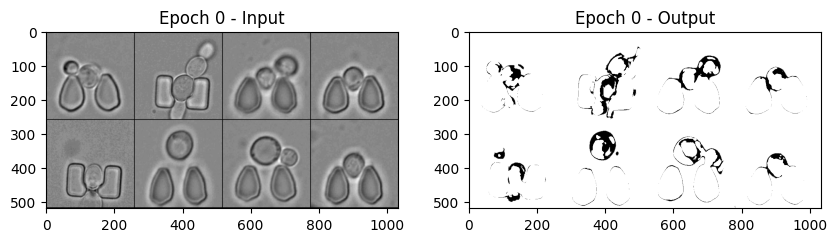

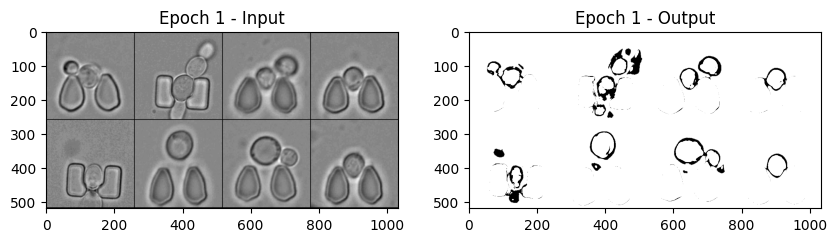

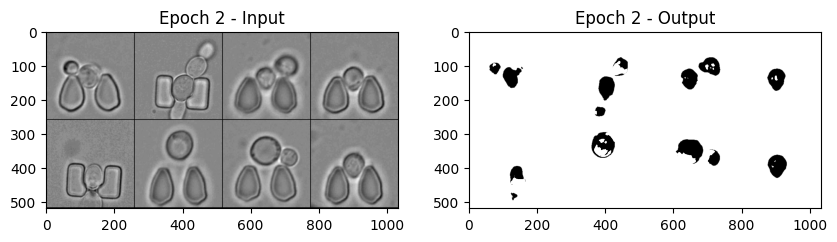

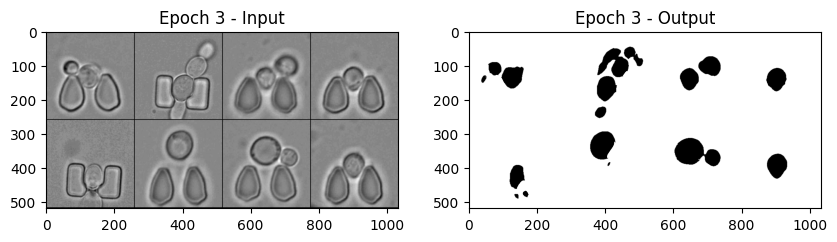

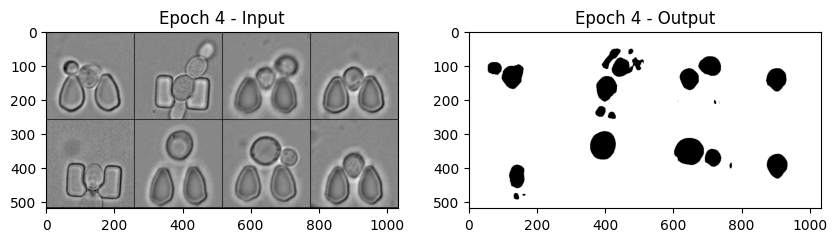

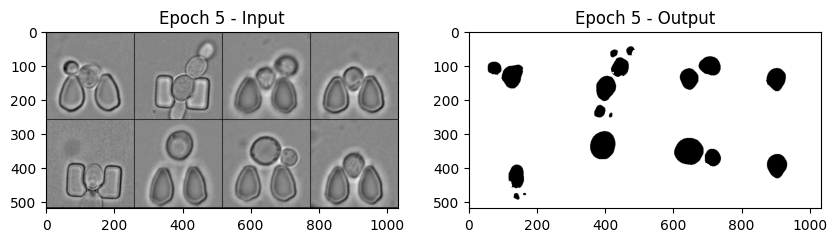

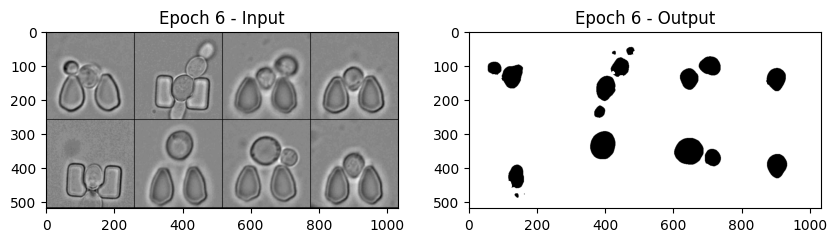

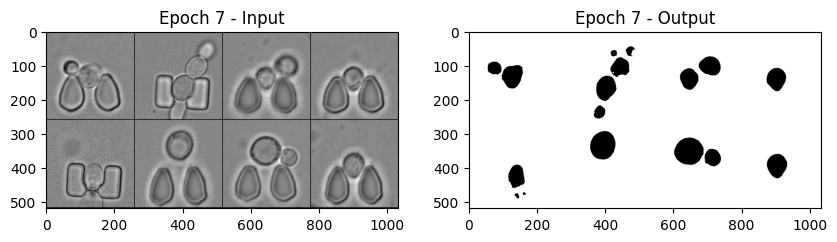

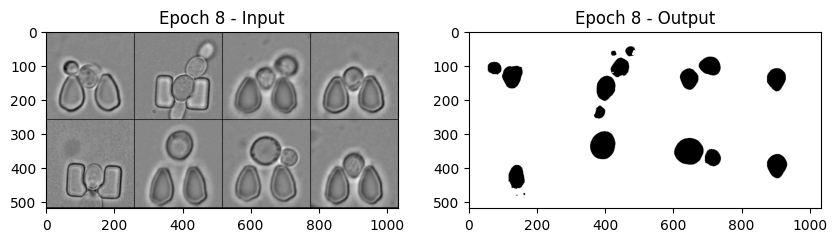

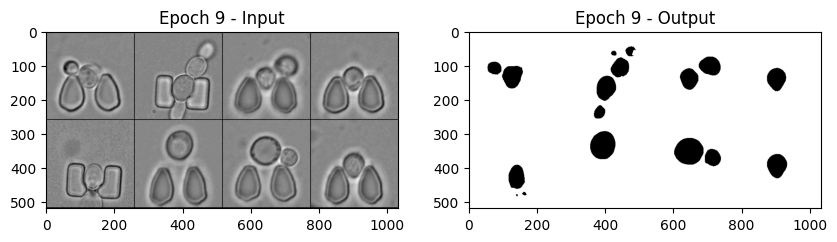

In [22]:
import matplotlib.pyplot as plt
from PIL import Image

def show_images_for_epochs(epochs):
    for epoch in epochs:
        input_img = Image.open(f"saved_images/epoch_{epoch}/input.png")
        output_img = Image.open(f"saved_images/epoch_{epoch}/output.png")
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_img)
        plt.title(f"Epoch {epoch} - Input")
        
        plt.subplot(1, 2, 2)
        plt.imshow(output_img)
        plt.title(f"Epoch {epoch} - Output")
        
        plt.show()

epochs_to_show = [i for i in range(10)]
show_images_for_epochs(epochs_to_show)


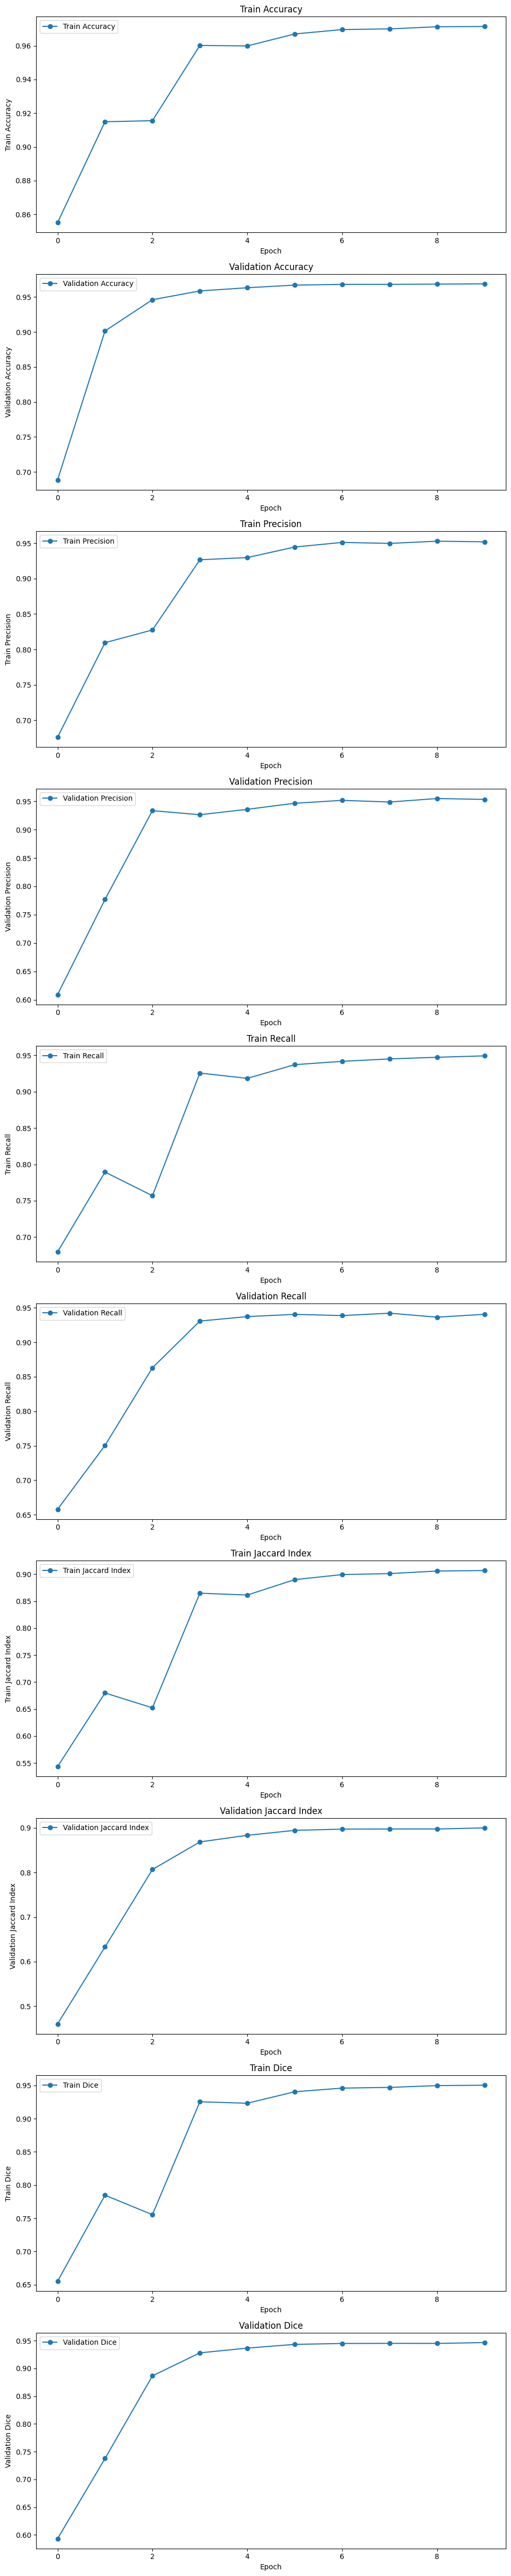

In [23]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('training_metrics_boundary_loss.csv')

def plot_metrics_from_csv(df):
    metrics = [
        ("train_MulticlassAccuracy", "Train Accuracy"),
        ("val_MulticlassAccuracy", "Validation Accuracy"),
        ("train_MulticlassPrecision", "Train Precision"),
        ("val_MulticlassPrecision", "Validation Precision"),
        ("train_MulticlassRecall", "Train Recall"),
        ("val_MulticlassRecall", "Validation Recall"),
        ("train_MulticlassJaccardIndex", "Train Jaccard Index"),
        ("val_MulticlassJaccardIndex", "Validation Jaccard Index"),
        ("train_Dice", "Train Dice"),
        ("val_Dice", "Validation Dice")
    ]
    
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, num_metrics * 5))
    
    for i, (metric_col, metric_name) in enumerate(metrics):
        axes[i].plot(df['epoch'], df[metric_col], label=metric_name, marker='o')
        axes[i].set_title(metric_name)
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric_name)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

plot_metrics_from_csv(df)



Можно заметить более что с первой эпохи у нас более выраженная граница, а также по графикам видно, что тренировочном датасете на второй эпохе во многих метриках наблюдается регресс и динамика обучения на первых эпохах идет быстрее



### Задание 4 (3 балла). Модификация архитектуры

Ваша задача - извлечь максимальную точность из модели, в которой будет не более 50k параметров. Для этого внесите правки в архитектуру модели.

В частности, попробуйте заменить в блоке `Down` комбинацию conv+maxpool на dilated conv (`nn.Conv2d(..., dilation=2)`). В остальном - полная свобода творчества, можете перерабатывать архитектуру как угодно.

Как обычно, запустите эксперимент (или несколько) с выводом всех графиков и картинок.

In [ ]:
class DilatedConv(nn.Module):
    """(Dilated Conv => [BN] => ReLU)"""
    
    def __init__(
        self, in_channels: int, out_channels: int, dilation: int = 2
    ) -> None:
        super().__init__()
        self.dilated_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.dilated_conv(x)

class DownWithDilatedConv(nn.Module):
    """Downscaling with dilated conv instead of maxpool + double conv"""
    
    def __init__(self, in_channels: int, out_channels: int, dilation: int = 2) -> None:
        super().__init__()
        self.dilated_conv = nn.Sequential(
            DilatedConv(in_channels, out_channels, dilation),
            DilatedConv(out_channels, out_channels, dilation)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.dilated_conv(x)

class UNetWithDilatedDown(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        """
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                DownWithDilatedConv(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        """
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        xs = []
        x = self.in_conv(x)

        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        logits = self.head(x)
        return logits


In [66]:
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pathlib import Path
import lightning.pytorch as L

torch.manual_seed(42)

datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=8,
)
datamodule.setup("fit")

new_model = UNetWithDilatedDown(n_channels=1, n_classes=3, channel_sizes=[8, 16, 32], bilinear=True)

lit_module = Lit(new_model, learning_rate=0.003)

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=30,
    logger=TensorBoardLogger(save_dir="."),
)

trainer.fit(
    model=lit_module,  
    datamodule=datamodule,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | UNetWithDilatedDown | 16.5 K | train
1 | train_metrics | MetricCollection    | 0      | train
2 | val_metrics   | MetricCollection    | 0      | train
--------------------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 0...
Saved predictions for epoch 0 in saved_images/epoch_0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 0...
Saved predictions for epoch 0 in saved_images/epoch_0
Epoch 0: {'epoch': 0, 'train_MulticlassAccuracy': 0.7762487530708313, 'train_MulticlassPrecision': 0.5361557602882385, 'train_MulticlassRecall': 0.5474467277526855, 'train_MulticlassJaccardIndex': 0.4157317876815796, 'train_Dice': 0.5244939923286438, 'val_MulticlassAccuracy': 0.6171699166297913, 'val_MulticlassPrecision': 0.49957436323165894, 'val_MulticlassRecall': 0.49387720227241516, 'val_MulticlassJaccardIndex': 0.3486677408218384, 'val_Dice': 0.47733598947525024}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 1...
Saved predictions for epoch 1 in saved_images/epoch_1
Epoch 1: {'epoch': 1, 'train_MulticlassAccuracy': 0.8354609608650208, 'train_MulticlassPrecision': 0.6741534471511841, 'train_MulticlassRecall': 0.5817252397537231, 'train_MulticlassJaccardIndex': 0.48114582896232605, 'train_Dice': 0.5899080634117126, 'val_MulticlassAccuracy': 0.8132504820823669, 'val_MulticlassPrecision': 0.665626049041748, 'val_MulticlassRecall': 0.5304178595542908, 'val_MulticlassJaccardIndex': 0.4471641778945923, 'val_Dice': 0.5633244514465332}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 2...
Saved predictions for epoch 2 in saved_images/epoch_2
Epoch 2: {'epoch': 2, 'train_MulticlassAccuracy': 0.8442156314849854, 'train_MulticlassPrecision': 0.6971811056137085, 'train_MulticlassRecall': 0.5855239033699036, 'train_MulticlassJaccardIndex': 0.4952927827835083, 'train_Dice': 0.6046415567398071, 'val_MulticlassAccuracy': 0.8218860030174255, 'val_MulticlassPrecision': 0.6868245005607605, 'val_MulticlassRecall': 0.5498900413513184, 'val_MulticlassJaccardIndex': 0.45895761251449585, 'val_Dice': 0.5679242014884949}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 3...
Saved predictions for epoch 3 in saved_images/epoch_3
Epoch 3: {'epoch': 3, 'train_MulticlassAccuracy': 0.8484433889389038, 'train_MulticlassPrecision': 0.7136018872261047, 'train_MulticlassRecall': 0.5922142863273621, 'train_MulticlassJaccardIndex': 0.5022302269935608, 'train_Dice': 0.6098167896270752, 'val_MulticlassAccuracy': 0.8276675343513489, 'val_MulticlassPrecision': 0.716363787651062, 'val_MulticlassRecall': 0.5555623769760132, 'val_MulticlassJaccardIndex': 0.4770785868167877, 'val_Dice': 0.5940053462982178}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 4...
Saved predictions for epoch 4 in saved_images/epoch_4
Epoch 4: {'epoch': 4, 'train_MulticlassAccuracy': 0.8575180768966675, 'train_MulticlassPrecision': 0.7376529574394226, 'train_MulticlassRecall': 0.6137849688529968, 'train_MulticlassJaccardIndex': 0.528057336807251, 'train_Dice': 0.6394860148429871, 'val_MulticlassAccuracy': 0.8383303284645081, 'val_MulticlassPrecision': 0.736736536026001, 'val_MulticlassRecall': 0.5848800539970398, 'val_MulticlassJaccardIndex': 0.5055537819862366, 'val_Dice': 0.6237155795097351}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 5...
Saved predictions for epoch 5 in saved_images/epoch_5
Epoch 5: {'epoch': 5, 'train_MulticlassAccuracy': 0.8648873567581177, 'train_MulticlassPrecision': 0.7536804676055908, 'train_MulticlassRecall': 0.6332693099975586, 'train_MulticlassJaccardIndex': 0.5492187738418579, 'train_Dice': 0.6621735692024231, 'val_MulticlassAccuracy': 0.8443043231964111, 'val_MulticlassPrecision': 0.7368162870407104, 'val_MulticlassRecall': 0.6058138608932495, 'val_MulticlassJaccardIndex': 0.5205842852592468, 'val_Dice': 0.6351273059844971}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 6...
Saved predictions for epoch 6 in saved_images/epoch_6
Epoch 6: {'epoch': 6, 'train_MulticlassAccuracy': 0.8678714632987976, 'train_MulticlassPrecision': 0.7624051570892334, 'train_MulticlassRecall': 0.6390974521636963, 'train_MulticlassJaccardIndex': 0.5563651323318481, 'train_Dice': 0.6687006950378418, 'val_MulticlassAccuracy': 0.8474628925323486, 'val_MulticlassPrecision': 0.7369548082351685, 'val_MulticlassRecall': 0.6233154535293579, 'val_MulticlassJaccardIndex': 0.5316863656044006, 'val_Dice': 0.6466706991195679}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 7...
Saved predictions for epoch 7 in saved_images/epoch_7
Epoch 7: {'epoch': 7, 'train_MulticlassAccuracy': 0.8691297769546509, 'train_MulticlassPrecision': 0.7636542320251465, 'train_MulticlassRecall': 0.6445128917694092, 'train_MulticlassJaccardIndex': 0.5602172613143921, 'train_Dice': 0.6726046800613403, 'val_MulticlassAccuracy': 0.8483441472053528, 'val_MulticlassPrecision': 0.7421985864639282, 'val_MulticlassRecall': 0.6222346425056458, 'val_MulticlassJaccardIndex': 0.5329381227493286, 'val_Dice': 0.6478338241577148}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 8...
Saved predictions for epoch 8 in saved_images/epoch_8
Epoch 8: {'epoch': 8, 'train_MulticlassAccuracy': 0.8695204257965088, 'train_MulticlassPrecision': 0.7668288946151733, 'train_MulticlassRecall': 0.6446578502655029, 'train_MulticlassJaccardIndex': 0.5616084933280945, 'train_Dice': 0.674140453338623, 'val_MulticlassAccuracy': 0.8499805927276611, 'val_MulticlassPrecision': 0.7469062805175781, 'val_MulticlassRecall': 0.6280072927474976, 'val_MulticlassJaccardIndex': 0.5374581217765808, 'val_Dice': 0.652617871761322}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 9...
Saved predictions for epoch 9 in saved_images/epoch_9
Epoch 9: {'epoch': 9, 'train_MulticlassAccuracy': 0.871023416519165, 'train_MulticlassPrecision': 0.7688174843788147, 'train_MulticlassRecall': 0.6501080393791199, 'train_MulticlassJaccardIndex': 0.5671749711036682, 'train_Dice': 0.6807860136032104, 'val_MulticlassAccuracy': 0.8502857685089111, 'val_MulticlassPrecision': 0.7483778595924377, 'val_MulticlassRecall': 0.6268479824066162, 'val_MulticlassJaccardIndex': 0.5414562821388245, 'val_Dice': 0.6598714590072632}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 10...
Saved predictions for epoch 10 in saved_images/epoch_10
Epoch 10: {'epoch': 10, 'train_MulticlassAccuracy': 0.8726864457130432, 'train_MulticlassPrecision': 0.7698756456375122, 'train_MulticlassRecall': 0.65838623046875, 'train_MulticlassJaccardIndex': 0.5745408535003662, 'train_Dice': 0.6889153122901917, 'val_MulticlassAccuracy': 0.8518944382667542, 'val_MulticlassPrecision': 0.7485820055007935, 'val_MulticlassRecall': 0.6366168260574341, 'val_MulticlassJaccardIndex': 0.5474216341972351, 'val_Dice': 0.6658399105072021}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 11...
Saved predictions for epoch 11 in saved_images/epoch_11
Epoch 11: {'epoch': 11, 'train_MulticlassAccuracy': 0.8724890947341919, 'train_MulticlassPrecision': 0.7696213126182556, 'train_MulticlassRecall': 0.6563755869865417, 'train_MulticlassJaccardIndex': 0.5727646946907043, 'train_Dice': 0.6866228580474854, 'val_MulticlassAccuracy': 0.8517624139785767, 'val_MulticlassPrecision': 0.7493953108787537, 'val_MulticlassRecall': 0.6341131925582886, 'val_MulticlassJaccardIndex': 0.5458740592002869, 'val_Dice': 0.6638033390045166}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 12...
Saved predictions for epoch 12 in saved_images/epoch_12
Epoch 12: {'epoch': 12, 'train_MulticlassAccuracy': 0.8727631568908691, 'train_MulticlassPrecision': 0.7704788446426392, 'train_MulticlassRecall': 0.6564936637878418, 'train_MulticlassJaccardIndex': 0.5732442140579224, 'train_Dice': 0.6870752573013306, 'val_MulticlassAccuracy': 0.8515531420707703, 'val_MulticlassPrecision': 0.750579833984375, 'val_MulticlassRecall': 0.6311980485916138, 'val_MulticlassJaccardIndex': 0.5442404747009277, 'val_Dice': 0.6618310809135437}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 13...
Saved predictions for epoch 13 in saved_images/epoch_13
Epoch 13: {'epoch': 13, 'train_MulticlassAccuracy': 0.8727350831031799, 'train_MulticlassPrecision': 0.7707993984222412, 'train_MulticlassRecall': 0.6563465595245361, 'train_MulticlassJaccardIndex': 0.5731998682022095, 'train_Dice': 0.6871095299720764, 'val_MulticlassAccuracy': 0.8515002131462097, 'val_MulticlassPrecision': 0.750627875328064, 'val_MulticlassRecall': 0.6307882070541382, 'val_MulticlassJaccardIndex': 0.5435740947723389, 'val_Dice': 0.6608219742774963}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 14...
Saved predictions for epoch 14 in saved_images/epoch_14
Epoch 14: {'epoch': 14, 'train_MulticlassAccuracy': 0.873631477355957, 'train_MulticlassPrecision': 0.773647665977478, 'train_MulticlassRecall': 0.65937340259552, 'train_MulticlassJaccardIndex': 0.5759763121604919, 'train_Dice': 0.6902774572372437, 'val_MulticlassAccuracy': 0.8519433736801147, 'val_MulticlassPrecision': 0.7511715888977051, 'val_MulticlassRecall': 0.6327662467956543, 'val_MulticlassJaccardIndex': 0.5456071496009827, 'val_Dice': 0.663506031036377}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 15...
Saved predictions for epoch 15 in saved_images/epoch_15
Epoch 15: {'epoch': 15, 'train_MulticlassAccuracy': 0.8727825284004211, 'train_MulticlassPrecision': 0.7710341811180115, 'train_MulticlassRecall': 0.6570643186569214, 'train_MulticlassJaccardIndex': 0.5737764239311218, 'train_Dice': 0.6879360675811768, 'val_MulticlassAccuracy': 0.8519981503486633, 'val_MulticlassPrecision': 0.7515568733215332, 'val_MulticlassRecall': 0.6324236392974854, 'val_MulticlassJaccardIndex': 0.545731246471405, 'val_Dice': 0.663631021976471}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 16...
Saved predictions for epoch 16 in saved_images/epoch_16
Epoch 16: {'epoch': 16, 'train_MulticlassAccuracy': 0.8734822869300842, 'train_MulticlassPrecision': 0.7727495431900024, 'train_MulticlassRecall': 0.6587755680084229, 'train_MulticlassJaccardIndex': 0.5756901502609253, 'train_Dice': 0.6898311972618103, 'val_MulticlassAccuracy': 0.8518122434616089, 'val_MulticlassPrecision': 0.7511885166168213, 'val_MulticlassRecall': 0.633085310459137, 'val_MulticlassJaccardIndex': 0.5447344779968262, 'val_Dice': 0.6622092127799988}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 17...
Saved predictions for epoch 17 in saved_images/epoch_17
Epoch 17: {'epoch': 17, 'train_MulticlassAccuracy': 0.8738164901733398, 'train_MulticlassPrecision': 0.7733829021453857, 'train_MulticlassRecall': 0.6592334508895874, 'train_MulticlassJaccardIndex': 0.576244056224823, 'train_Dice': 0.6902844905853271, 'val_MulticlassAccuracy': 0.8519492745399475, 'val_MulticlassPrecision': 0.7505738735198975, 'val_MulticlassRecall': 0.6343536376953125, 'val_MulticlassJaccardIndex': 0.5459978580474854, 'val_Dice': 0.663888692855835}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 18...
Saved predictions for epoch 18 in saved_images/epoch_18
Epoch 18: {'epoch': 18, 'train_MulticlassAccuracy': 0.8729099631309509, 'train_MulticlassPrecision': 0.7715389728546143, 'train_MulticlassRecall': 0.6571248769760132, 'train_MulticlassJaccardIndex': 0.5736902356147766, 'train_Dice': 0.6877707839012146, 'val_MulticlassAccuracy': 0.8521115183830261, 'val_MulticlassPrecision': 0.7517383694648743, 'val_MulticlassRecall': 0.6330686807632446, 'val_MulticlassJaccardIndex': 0.5459461808204651, 'val_Dice': 0.6636828184127808}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 19...
Saved predictions for epoch 19 in saved_images/epoch_19
Epoch 19: {'epoch': 19, 'train_MulticlassAccuracy': 0.8730000853538513, 'train_MulticlassPrecision': 0.7713272571563721, 'train_MulticlassRecall': 0.6576946973800659, 'train_MulticlassJaccardIndex': 0.5744565725326538, 'train_Dice': 0.6885988712310791, 'val_MulticlassAccuracy': 0.8520968556404114, 'val_MulticlassPrecision': 0.7516818642616272, 'val_MulticlassRecall': 0.633434534072876, 'val_MulticlassJaccardIndex': 0.5463029146194458, 'val_Dice': 0.6643186807632446}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 20...
Saved predictions for epoch 20 in saved_images/epoch_20
Epoch 20: {'epoch': 20, 'train_MulticlassAccuracy': 0.8739427924156189, 'train_MulticlassPrecision': 0.7740292549133301, 'train_MulticlassRecall': 0.6598143577575684, 'train_MulticlassJaccardIndex': 0.5766997337341309, 'train_Dice': 0.690822184085846, 'val_MulticlassAccuracy': 0.8517711162567139, 'val_MulticlassPrecision': 0.7510935068130493, 'val_MulticlassRecall': 0.632479727268219, 'val_MulticlassJaccardIndex': 0.5447053909301758, 'val_Dice': 0.6622448563575745}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 21...
Saved predictions for epoch 21 in saved_images/epoch_21
Epoch 21: {'epoch': 21, 'train_MulticlassAccuracy': 0.8735220432281494, 'train_MulticlassPrecision': 0.7732735872268677, 'train_MulticlassRecall': 0.6596864461898804, 'train_MulticlassJaccardIndex': 0.5762289762496948, 'train_Dice': 0.6906358599662781, 'val_MulticlassAccuracy': 0.8519866466522217, 'val_MulticlassPrecision': 0.7509772181510925, 'val_MulticlassRecall': 0.6340528130531311, 'val_MulticlassJaccardIndex': 0.5459532737731934, 'val_Dice': 0.6638029217720032}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 22...
Saved predictions for epoch 22 in saved_images/epoch_22
Epoch 22: {'epoch': 22, 'train_MulticlassAccuracy': 0.8735982775688171, 'train_MulticlassPrecision': 0.7730430364608765, 'train_MulticlassRecall': 0.6596038341522217, 'train_MulticlassJaccardIndex': 0.5761926770210266, 'train_Dice': 0.6904672384262085, 'val_MulticlassAccuracy': 0.8519716858863831, 'val_MulticlassPrecision': 0.7511023283004761, 'val_MulticlassRecall': 0.6343777179718018, 'val_MulticlassJaccardIndex': 0.5462435483932495, 'val_Dice': 0.6644522547721863}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 23...
Saved predictions for epoch 23 in saved_images/epoch_23
Epoch 23: {'epoch': 23, 'train_MulticlassAccuracy': 0.873879611492157, 'train_MulticlassPrecision': 0.7736968994140625, 'train_MulticlassRecall': 0.6598125696182251, 'train_MulticlassJaccardIndex': 0.5766571760177612, 'train_Dice': 0.6908279657363892, 'val_MulticlassAccuracy': 0.8517163395881653, 'val_MulticlassPrecision': 0.751426100730896, 'val_MulticlassRecall': 0.6307751536369324, 'val_MulticlassJaccardIndex': 0.5444365739822388, 'val_Dice': 0.6620500683784485}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 24...
Saved predictions for epoch 24 in saved_images/epoch_24
Epoch 24: {'epoch': 24, 'train_MulticlassAccuracy': 0.8738469481468201, 'train_MulticlassPrecision': 0.7730467319488525, 'train_MulticlassRecall': 0.6591025590896606, 'train_MulticlassJaccardIndex': 0.5761237144470215, 'train_Dice': 0.6900455951690674, 'val_MulticlassAccuracy': 0.8521096110343933, 'val_MulticlassPrecision': 0.7511365413665771, 'val_MulticlassRecall': 0.6343366503715515, 'val_MulticlassJaccardIndex': 0.5464580655097961, 'val_Dice': 0.664400577545166}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 25...
Saved predictions for epoch 25 in saved_images/epoch_25
Epoch 25: {'epoch': 25, 'train_MulticlassAccuracy': 0.8730059266090393, 'train_MulticlassPrecision': 0.7717810869216919, 'train_MulticlassRecall': 0.657933235168457, 'train_MulticlassJaccardIndex': 0.5746426582336426, 'train_Dice': 0.6887644529342651, 'val_MulticlassAccuracy': 0.8524350523948669, 'val_MulticlassPrecision': 0.7517125606536865, 'val_MulticlassRecall': 0.6372047662734985, 'val_MulticlassJaccardIndex': 0.5489444136619568, 'val_Dice': 0.6680136919021606}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 26...
Saved predictions for epoch 26 in saved_images/epoch_26
Epoch 26: {'epoch': 26, 'train_MulticlassAccuracy': 0.8737967014312744, 'train_MulticlassPrecision': 0.7737991809844971, 'train_MulticlassRecall': 0.6595263481140137, 'train_MulticlassJaccardIndex': 0.5764075517654419, 'train_Dice': 0.6906399726867676, 'val_MulticlassAccuracy': 0.8519093990325928, 'val_MulticlassPrecision': 0.7518343925476074, 'val_MulticlassRecall': 0.6314862370491028, 'val_MulticlassJaccardIndex': 0.54515540599823, 'val_Dice': 0.6628050804138184}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 27...
Saved predictions for epoch 27 in saved_images/epoch_27
Epoch 27: {'epoch': 27, 'train_MulticlassAccuracy': 0.8734769225120544, 'train_MulticlassPrecision': 0.7730604410171509, 'train_MulticlassRecall': 0.6593978404998779, 'train_MulticlassJaccardIndex': 0.576072096824646, 'train_Dice': 0.6904006004333496, 'val_MulticlassAccuracy': 0.85185706615448, 'val_MulticlassPrecision': 0.7510590553283691, 'val_MulticlassRecall': 0.6325319409370422, 'val_MulticlassJaccardIndex': 0.544704258441925, 'val_Dice': 0.6619900465011597}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 28...
Saved predictions for epoch 28 in saved_images/epoch_28
Epoch 28: {'epoch': 28, 'train_MulticlassAccuracy': 0.8737124800682068, 'train_MulticlassPrecision': 0.7740006446838379, 'train_MulticlassRecall': 0.6595919132232666, 'train_MulticlassJaccardIndex': 0.5765857696533203, 'train_Dice': 0.6910009384155273, 'val_MulticlassAccuracy': 0.8521202206611633, 'val_MulticlassPrecision': 0.7513492107391357, 'val_MulticlassRecall': 0.6351554989814758, 'val_MulticlassJaccardIndex': 0.5466930270195007, 'val_Dice': 0.6647601127624512}


Validation: |          | 0/? [00:00<?, ?it/s]

save_images is True
Saving predictions for epoch 29...


`Trainer.fit` stopped: `max_epochs=30` reached.


Saved predictions for epoch 29 in saved_images/epoch_29
Epoch 29: {'epoch': 29, 'train_MulticlassAccuracy': 0.8735672235488892, 'train_MulticlassPrecision': 0.7732884883880615, 'train_MulticlassRecall': 0.6593216061592102, 'train_MulticlassJaccardIndex': 0.5760688185691833, 'train_Dice': 0.6903171539306641, 'val_MulticlassAccuracy': 0.8517783284187317, 'val_MulticlassPrecision': 0.75058913230896, 'val_MulticlassRecall': 0.6326484680175781, 'val_MulticlassJaccardIndex': 0.544906497001648, 'val_Dice': 0.6625039577484131}


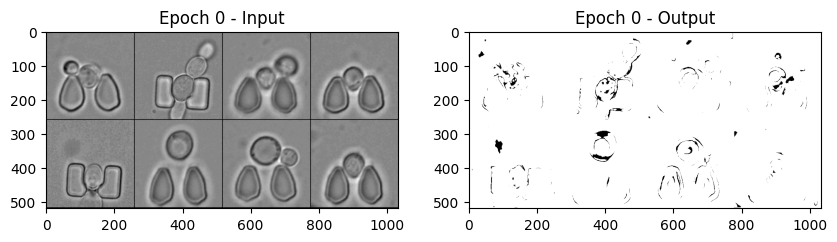

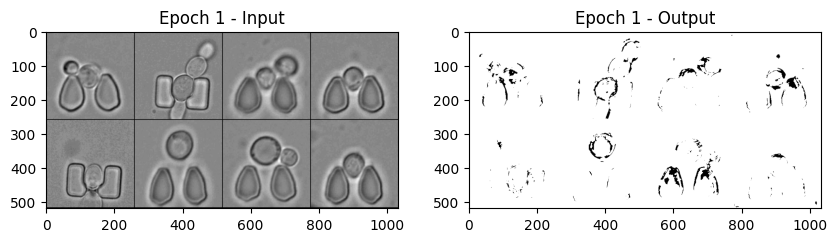

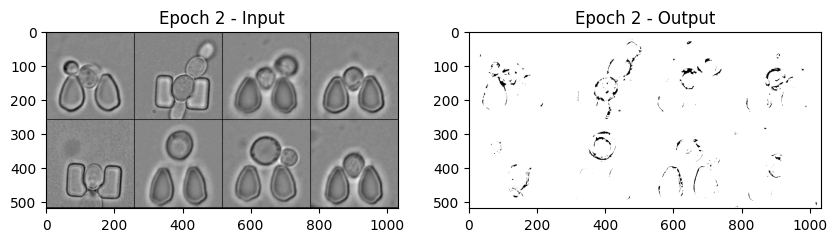

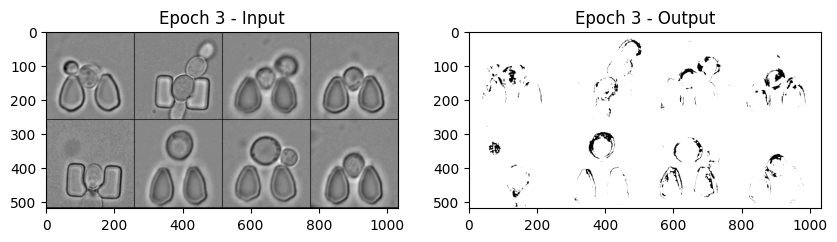

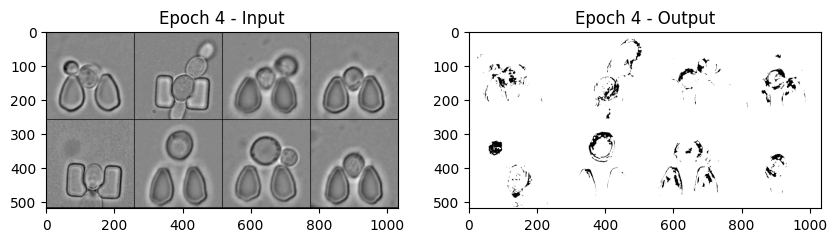

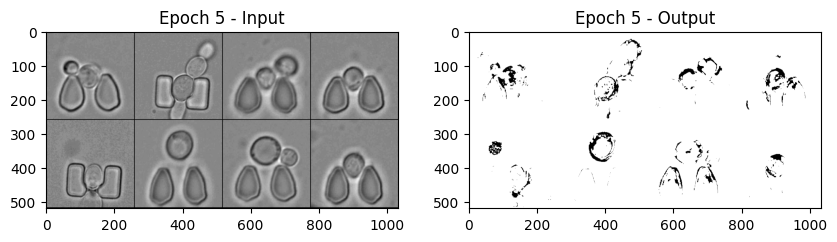

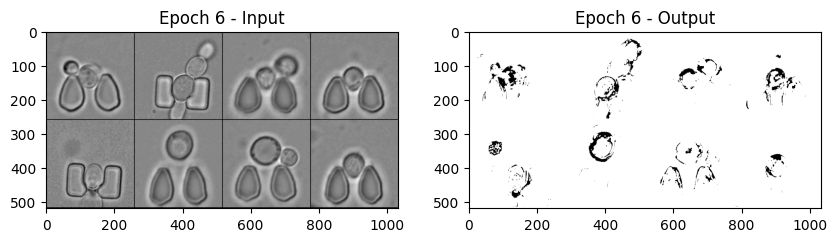

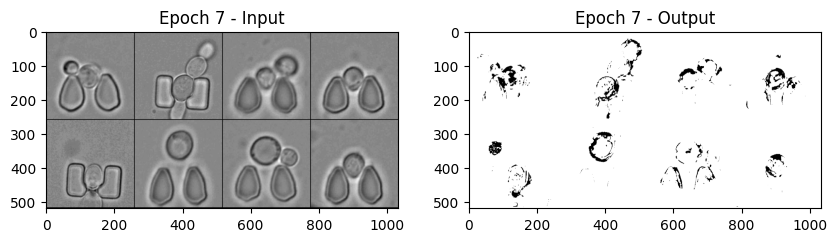

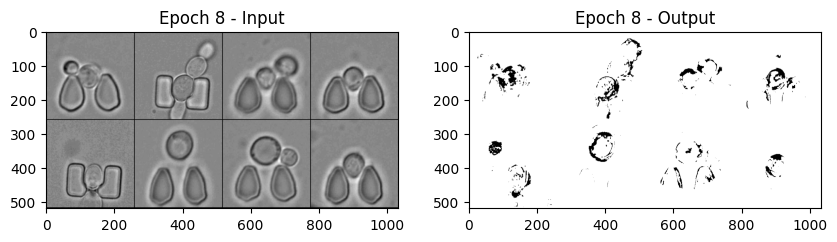

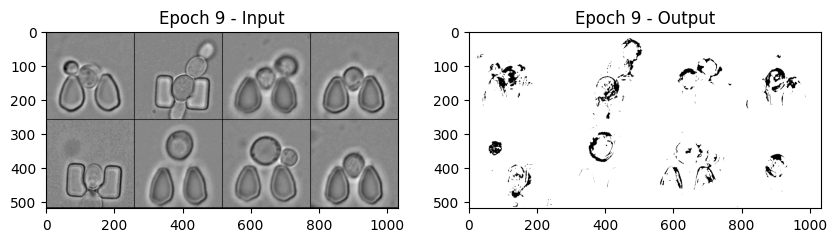

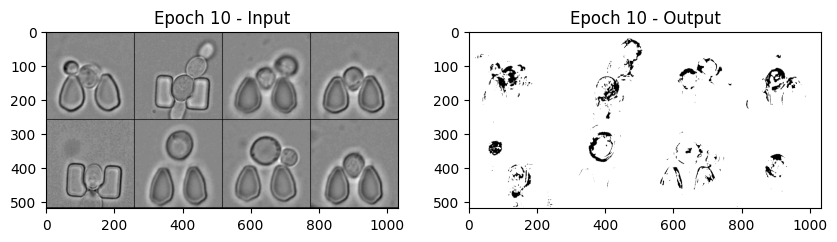

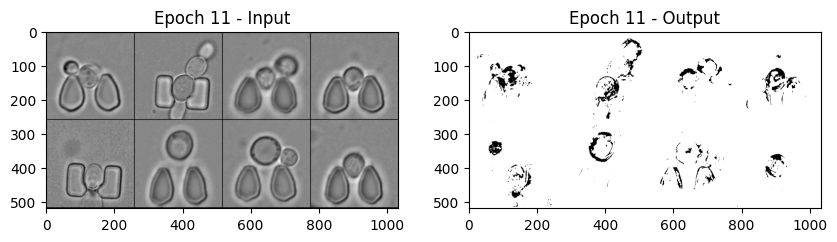

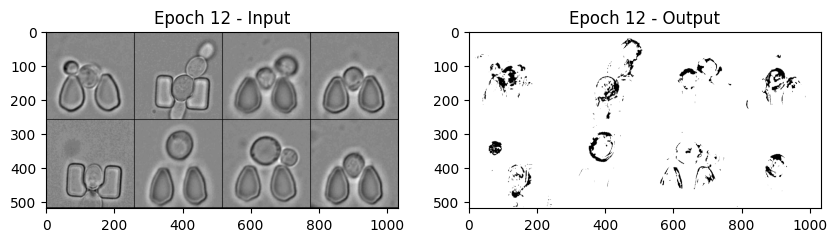

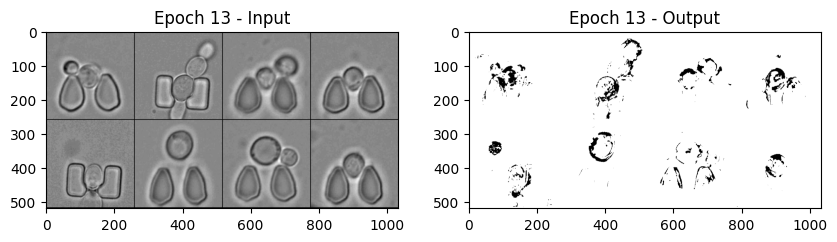

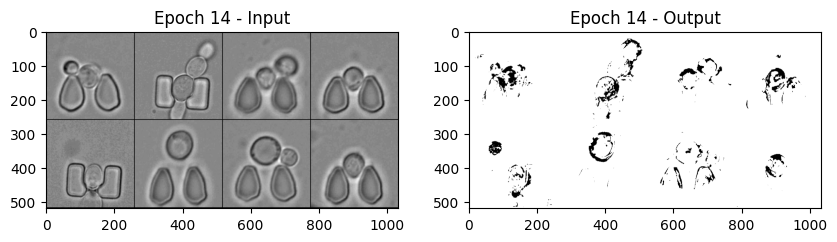

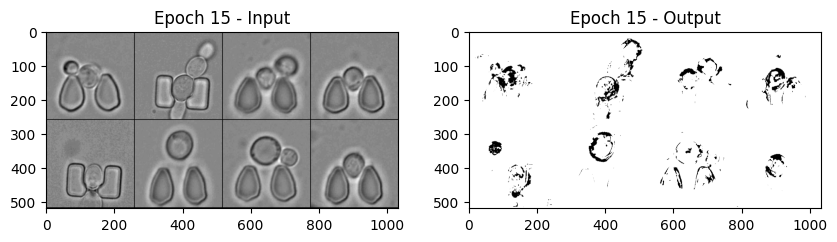

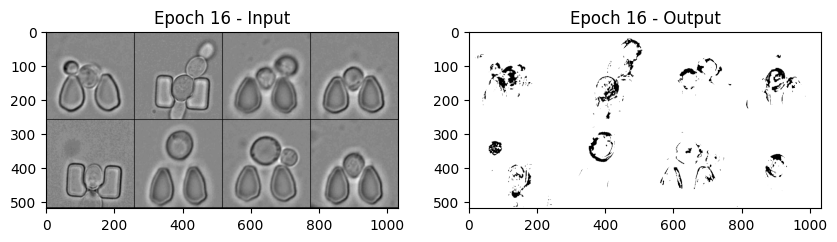

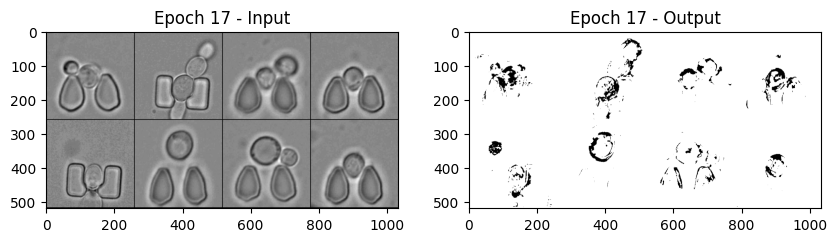

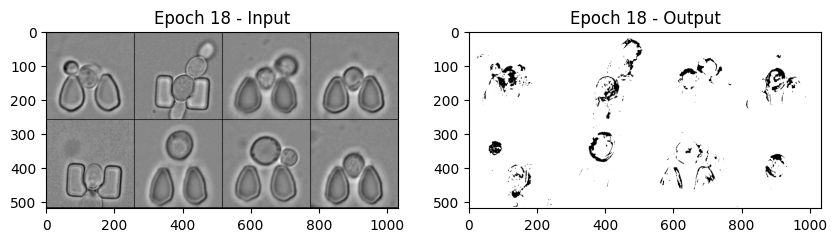

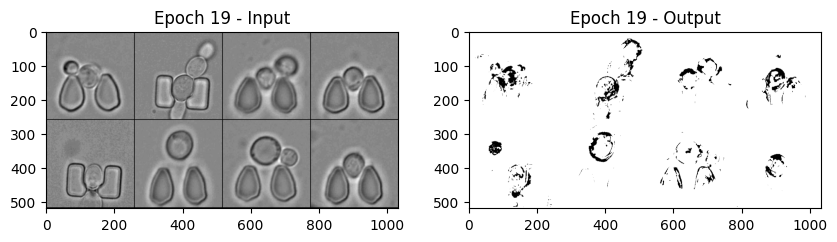

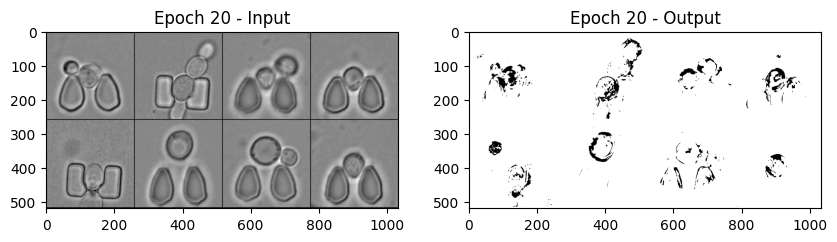

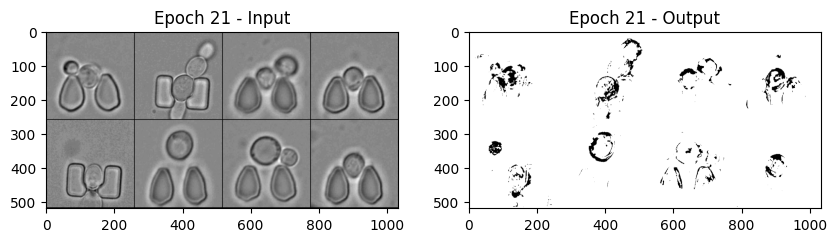

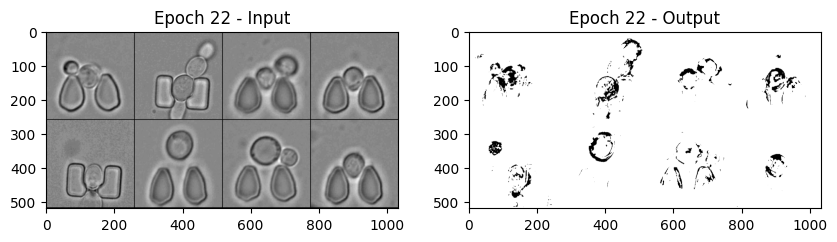

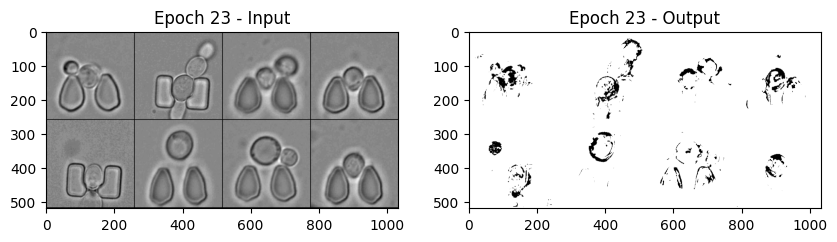

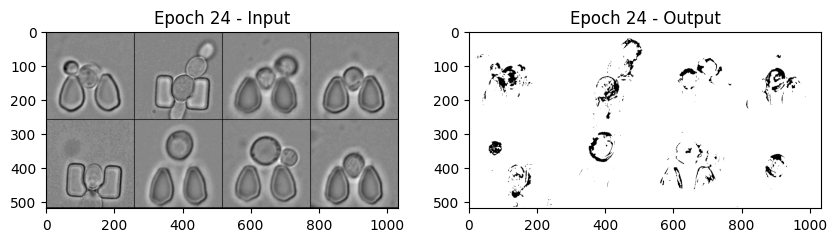

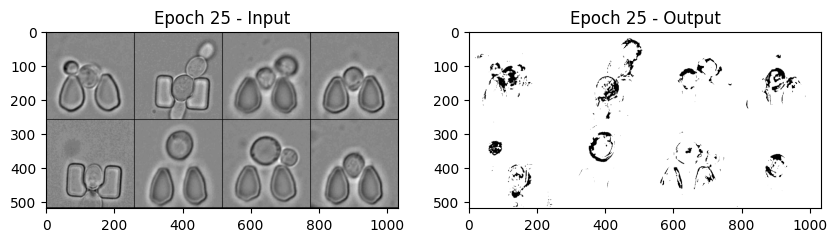

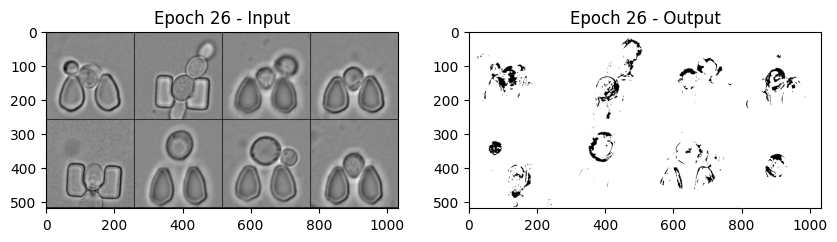

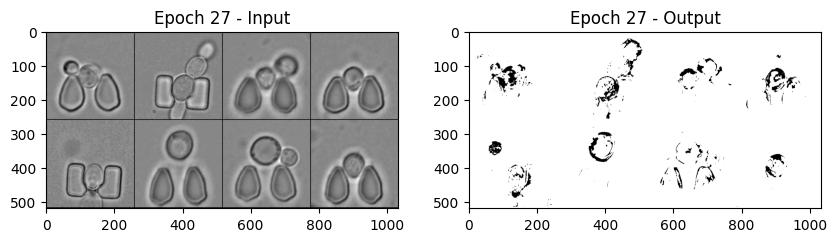

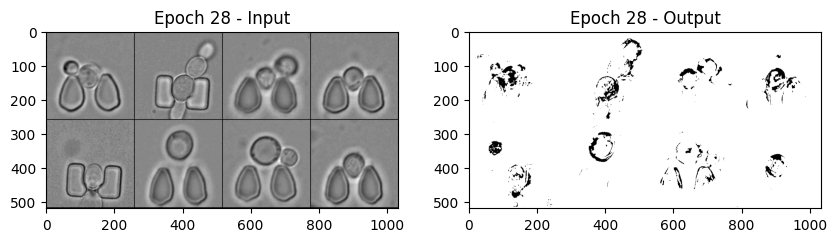

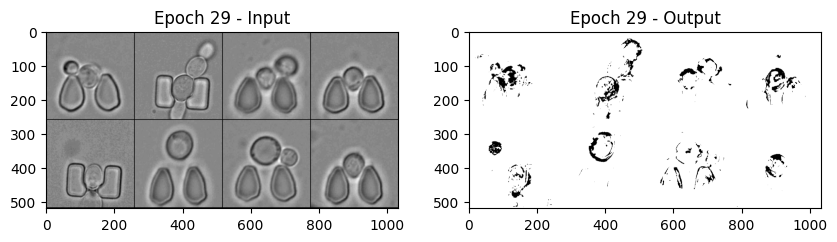

In [68]:
import matplotlib.pyplot as plt
from PIL import Image

def show_images_for_epochs(epochs):
    for epoch in epochs:
        input_img = Image.open(f"saved_images/epoch_{epoch}/input.png")
        output_img = Image.open(f"saved_images/epoch_{epoch}/output.png")
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_img)
        plt.title(f"Epoch {epoch} - Input")
        
        plt.subplot(1, 2, 2)
        plt.imshow(output_img)
        plt.title(f"Epoch {epoch} - Output")
        
        plt.show()

epochs_to_show = [i for i in range(30)]
show_images_for_epochs(epochs_to_show)

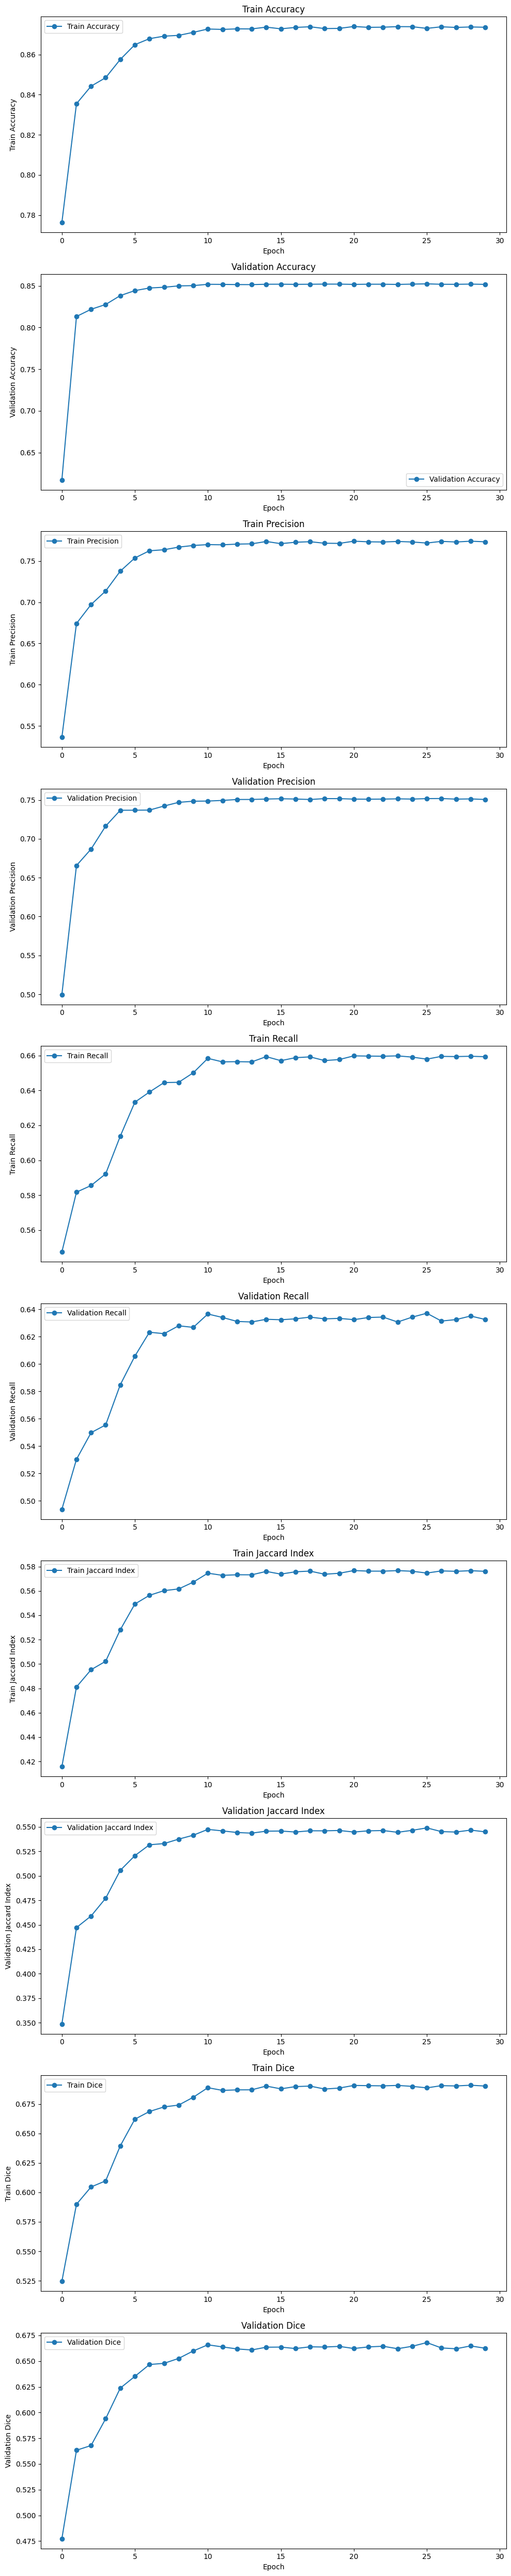

In [69]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('training_metrics.csv')

def plot_metrics_from_csv(df):
    metrics = [
        ("train_MulticlassAccuracy", "Train Accuracy"),
        ("val_MulticlassAccuracy", "Validation Accuracy"),
        ("train_MulticlassPrecision", "Train Precision"),
        ("val_MulticlassPrecision", "Validation Precision"),
        ("train_MulticlassRecall", "Train Recall"),
        ("val_MulticlassRecall", "Validation Recall"),
        ("train_MulticlassJaccardIndex", "Train Jaccard Index"),
        ("val_MulticlassJaccardIndex", "Validation Jaccard Index"),
        ("train_Dice", "Train Dice"),
        ("val_Dice", "Validation Dice")
    ]
    
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, num_metrics * 5))
    
    for i, (metric_col, metric_name) in enumerate(metrics):
        axes[i].plot(df['epoch'], df[metric_col], label=metric_name, marker='o')
        axes[i].set_title(metric_name)
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric_name)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

plot_metrics_from_csv(df)
